# Pipline start

In [23]:
import glob
import os
import io

import networkx as nx
import csv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Lambda

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import average_precision_score, f1_score

# For embeddings (graph/text)
from node2vec.node2vec import Node2Vec
import gensim
import spacy
from scipy.spatial.distance import cosine

## Building Graph

In [2]:
toy = False # Set to true for debug, faster run
it_toy_limit = 1000
it = 0
# First read and create the graph using the training dataset
G = nx.Graph()
DG = nx.DiGraph()
with open("data/training.txt", "r") as f:
    for line in tqdm(f):
        line = line.split()
        if line[2] == "1":
            G.add_edge(line[0], line[1])
            DG.add_edge(line[0], line[1])
            it += 1
            if toy and it >= it_toy_limit:
                break
        if line[2] == "0":
            G.add_node(line[0])
            G.add_node(line[1])
            DG.add_node(line[0])
            DG.add_node(line[1])

453797it [00:02, 176750.36it/s]


In [3]:
def info(graph):
    """
    Prints some basic statistics of a graph
    """
    print('Type:', 'Directed' if isinstance(graph, nx.DiGraph) else 'Undirected')
    n = graph.number_of_nodes()
    e = graph.number_of_edges()
    print('Nodes:', n)
    print('Edges:', e)
    if not isinstance(graph, nx.DiGraph):
        print('Connected components:', nx.algorithms.components.number_connected_components(graph))
    degrees = graph.degree()
    sum_of_edges = sum([d[1] for d in degrees])
    print('Mean degree:', sum_of_edges // n)

In [4]:
info(G)

Type: Undirected
Nodes: 33226
Edges: 283623
Connected components: 67
Mean degree: 17


In [5]:
info(DG)

Type: Directed
Nodes: 33226
Edges: 283623
Mean degree: 17


## Feature engineering

In [6]:
A = nx.adjacency_matrix(G) 

In [7]:
print("shape Adjacency matrix A: ", np.shape(A))
nid_to_index = {nid:i for i, nid in enumerate(G.nodes)}

shape Adjacency matrix A:  (33226, 33226)


### UMAP computation

In [12]:
import umap

override_umap = False
nc = 5
n_neighbors = 17 # 17
min_dist = 0.0 # 0.1
metric = "jaccard"

if override_umap:
    print("Running UMAP...")
    reducer = umap.UMAP(
        n_components=nc,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        verbose=True)
    umap_emb = reducer.fit_transform(A)

    with open("embeddings/umap-3.npy", "wb") as f:
        np.save(f, umap_emb)
else:
    print("Loading pre-computed UMAP embeddings...")
    with open("embeddings/umap-3.npy", "rb") as f:
        umap_emb = np.load(f)
print("Shape UMAP embeddings: ", np.shape(umap_emb))

Running UMAP...
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='jaccard',
     metric_kwds=None, min_dist=0.0, n_components=5, n_epochs=None,
     n_neighbors=17, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Sun Dec 29 10:43:20 2019 Finding Nearest Neighbors
Sun Dec 29 10:43:20 2019 Building RP forest with 14 trees
Sun Dec 29 10:43:48 2019 NN descent for 15 iterations


/Users/romainegele/opt/anaconda3/envs/dh/lib/python3.7/site-packages/umap/sparse.py:247: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../opt/anaconda3/envs/dh/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/Users/romainegele/opt/anaconda3/envs/dh/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parall

	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
	 7  /  15
	 8  /  15
	 9  /  15
	 10  /  15
Sun Dec 29 10:48:59 2019 Finished Nearest Neighbor Search
Sun Dec 29 10:49:02 2019 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Dec 29 10:49:50 2019 Finished embedding
Shape UMAP embeddings:  (33226, 5)


### UMAP Embeddings visualisation

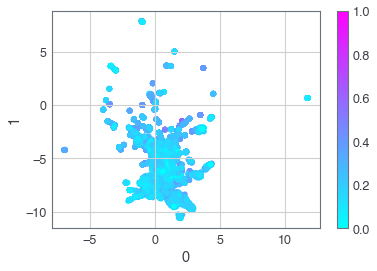

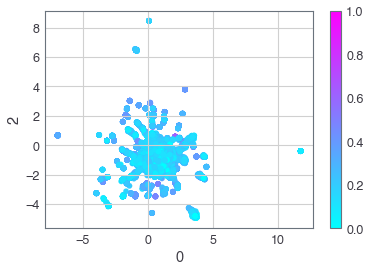

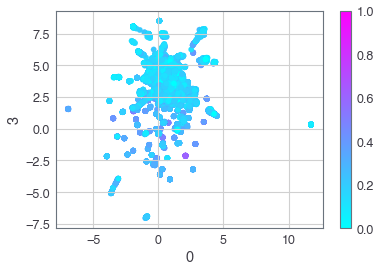

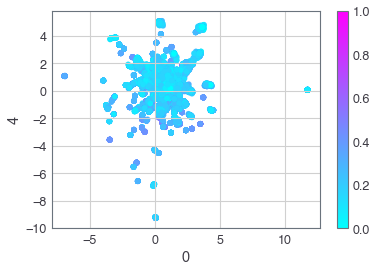

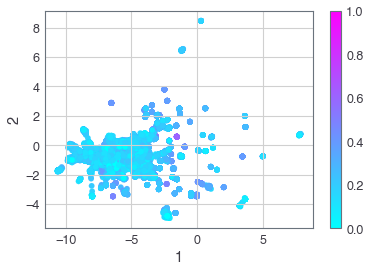

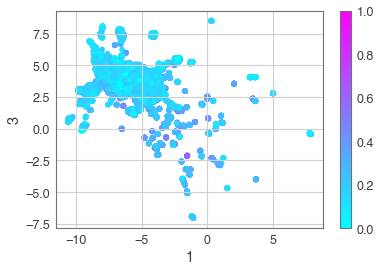

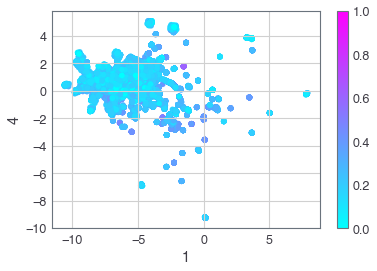

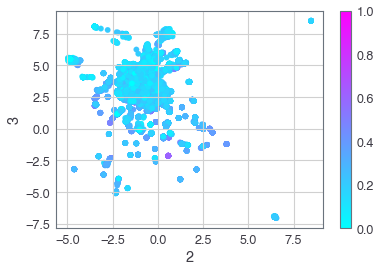

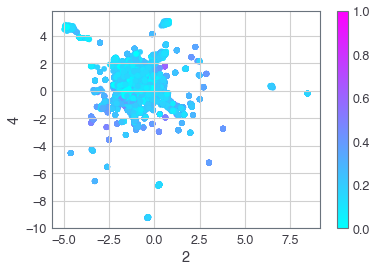

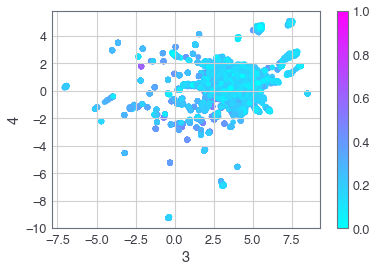

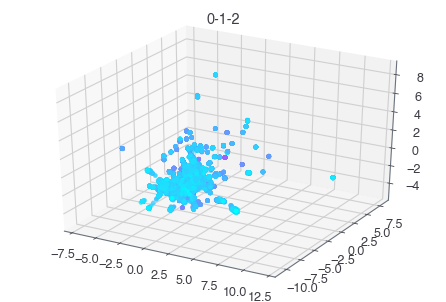

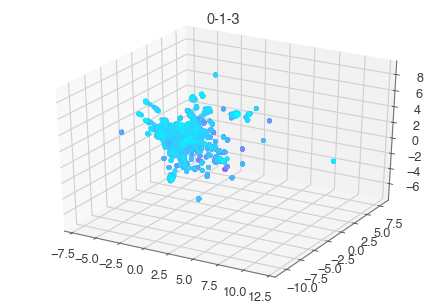

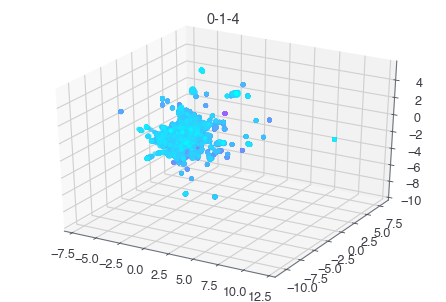

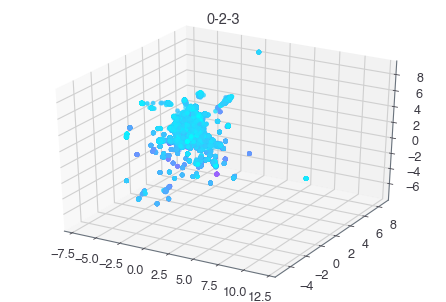

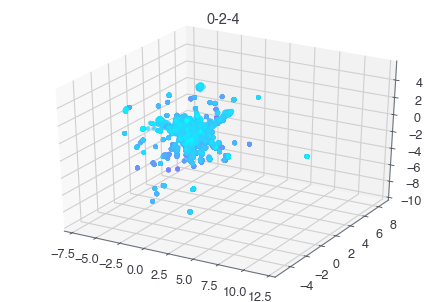

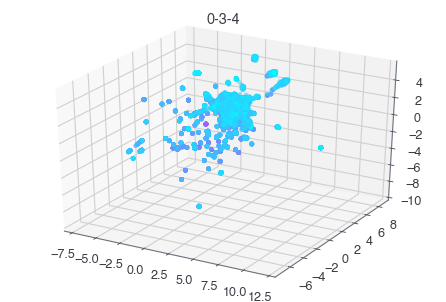

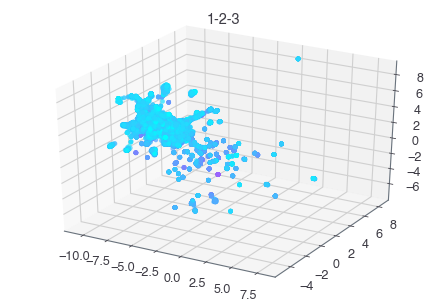

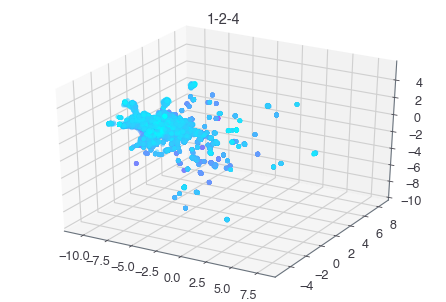

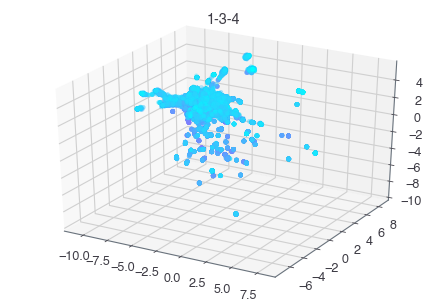

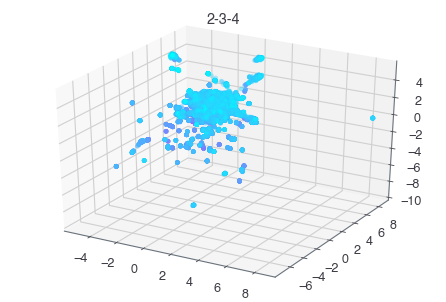

In [14]:
N = G.number_of_nodes()
max_degree = max([d[1] for d in G.degree()])
c = [np.log(d[1])/np.log(max_degree) if d[1] > 0 else 0 for d in G.degree()]
cmap = plt.get_cmap('cool')

for i in range(nc):
    for j in range(i+1, nc):
            plt.scatter(umap_emb[:, i], umap_emb[:, j], c=c, cmap=cmap)
            plt.xlabel(i)
            plt.ylabel(j)
            plt.colorbar()
            plt.show()

from mpl_toolkits.mplot3d import Axes3D

for i in range(nc):
    for j in range(i+1, nc):
        for k in range(j+1, nc):
            fig = plt.figure()
            xs = umap_emb[:, i]
            ys = umap_emb[:, j]
            zs = umap_emb[:, k]
            ax = ax = Axes3D(fig)
            ax.scatter(xs, ys, zs, c=c, cmap=cmap)
            plt.title(f"{i}-{j}-{k}")
            plt.show()

### UMAP training set to evaluate hyper-parameter with Random Forest

In [15]:
Xumap = []
y = []
add_sym = True # Set to true if you want to had symetrical data non present in G
with open("data/training.txt", "r") as f:
    for line in tqdm(f):
        line = line.split()
        n1, n2 = line[0], line[1]
        Xumap.append(np.concatenate([
            umap_emb[nid_to_index[n1]], 
            umap_emb[nid_to_index[n2]],
        ]))
        if line[2] == "1":
            y.append([1.0])
            it += 1
            if toy and it >= it_toy_limit:
                break
        else:
            y.append([0.0])

        if add_sym and not(G.has_edge(n2, n1)):
            Xumap.append(np.concatenate([
                umap_emb[nid_to_index[n2]], 
                umap_emb[nid_to_index[n1]],
            ]))
            y.append([0.0])

Xumap = np.array(Xumap)
y = np.array(y)
print("Shape Xumap: ", np.shape(Xumap))
print("Shape y: ", np.shape(y))

453797it [00:03, 117728.88it/s]


Shape Xumap:  (623940, 10)
Shape y:  (623940, 1)


In [16]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_valid, y_train, y_valid = train_test_split(Xumap, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(max_depth=10, random_state=42, verbose=1, n_jobs=6)
clf.fit(X_train, y_train)

/Users/romainegele/opt/anaconda3/envs/dh/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/romainegele/opt/anaconda3/envs/dh/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.8s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=6,
                       oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

In [17]:
y_pred = clf.predict(X_train)
thresh = 0.5

predictions = (y_pred >= thresh).astype(int).flatten()
acc = np.sum(predictions == y_train.flatten()) / len(predictions)
f1s = f1_score(predictions, y_train.flatten())

print("Acc train: ", acc)
print("F1 train: ", f1s)

y_pred = clf.predict(X_valid)

predictions = (y_pred >= thresh).astype(int).flatten()
acc = np.sum(predictions == y_valid.flatten()) / len(predictions)
f1s = f1_score(predictions, y_valid.flatten())

print("Acc valid: ", acc)
print("F1 valid: ", f1s)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s finished


Acc train:  0.8819727346013171
F1 train:  0.8640778838684084


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s finished


Acc valid:  0.8784415811482217
F1 valid:  0.8597398667391438


### Jaccard Coefficient

In [18]:
def get_jc(G, n1, n2):
    try:
        coef = [
            [u, v, p] for u, v, p in nx.jaccard_coefficient(G, [(n1, n2)])
        ][0]
        return coef[2]
    except:
        return 0.0

### Node2vec & Word2Vec

In [19]:
def load_embeddings(filename):
    """
    Loads keyed vectors to a dict
    """
    model = {}
    with open('./embeddings/' + filename, 'r') as file:
        line = file.readline()
        dims = line.strip().split()
        total_vecs = int(dims[0])
        model['dim'] = int(dims[1])
        while line:
            line = file.readline()
            kvec = line.strip().split()
            if len(kvec) == 0:
                break
            model[kvec[0]] = np.array(kvec[1:]).astype(np.float)
            assert(model['dim'] == len(model[kvec[0]])), 'Incomplete vectors in ' + filename
    assert(len(model) - 1 == total_vecs), 'Not enough vectors in ' + filename
    print('Loaded', './embeddings/' + filename, 'to a', model['dim'], 'dimensional model')
    return model

In [20]:
file_node_vecs = 'node2vec.model'
file_text_vecs = 'word2vec_300.kv'

node_emb = load_embeddings(file_node_vecs)
text_emb = load_embeddings(file_text_vecs)

Loaded ./embeddings/node2vec.model to a 128 dimensional model
Loaded ./embeddings/word2vec_300.kv to a 300 dimensional model


## Building training data

In [195]:
X = []
y = []
add_sym = True # Set to true if you want to had symetrical data non present in G
override_training_data = False
it = 0
if override_training_data:
    with open("data/training.txt", "r") as f:
        for line in tqdm(f):
            line = line.split()
            n1, n2 = line[0], line[1]
            X.append(np.concatenate([
                umap_emb[nid_to_index[n1]], 
                umap_emb[nid_to_index[n2]],
                node_emb[n1], 
                node_emb[n2],
                text_emb[n1],
                text_emb[n2],
                [DG.in_degree[n1], DG.out_degree[n1]],
                [DG.in_degree[n2], DG.out_degree[n2]],
                [get_jc(G, n1, n2)]]))
            if line[2] == "1":
                y.append([1.0])
                it += 1
                if toy and it >= it_toy_limit:
                    break
            else:
                y.append([0.0])

            if add_sym and not(G.has_edge(n2, n1)):
                X.append(np.concatenate([
                    umap_emb[nid_to_index[n2]], 
                    umap_emb[nid_to_index[n1]],
                    node_emb[n2], 
                    node_emb[n1],
                    text_emb[n2],
                    text_emb[n1],
                    [DG.in_degree[n2], DG.out_degree[n2]],
                    [DG.in_degree[n1], DG.out_degree[n1]],
                    [0.0]]))
                y.append([0.0])

    X = np.array(X)
    y = np.array(y)
    
    with open("embeddings/trainX_part1.npy", "wb") as f:
        np.save(f, X)

    with open("embeddings/trainy.npy", "wb") as f:
        np.save(f, y)
else:
    with open("embeddings/trainX_part1.npy", "rb") as f:
        X = np.load(f)

    with open("embeddings/trainy.npy", "rb") as f:
        y = np.load(f)
print("Shape X: ", np.shape(X))
print("Shape y: ", np.shape(y))

Shape X:  (623940, 871)
Shape y:  (623940, 1)


In [196]:
# Concatenate remaining features
with open("embeddings/trainX_part2.npy", "rb") as f:
    X = np.concatenate([X, np.load(f)], axis=1)
print("Shape X: ", np.shape(X))

Shape X:  (623940, 878)


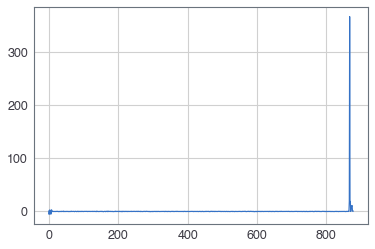

In [197]:
# Visualisatin of means
M = np.mean(X, axis=0)
np.shape(M)

plt.plot(M)
plt.show()

imax = np.argmax(M)

## Preprocessing

In [198]:
preprocessor = Pipeline([
        ('minmaxscaler', MinMaxScaler()),
#         ('robustscaler', RobustScaler()), # for outliers
        ('stdscaler', StandardScaler()),
    ])

X = preprocessor.fit_transform(X)

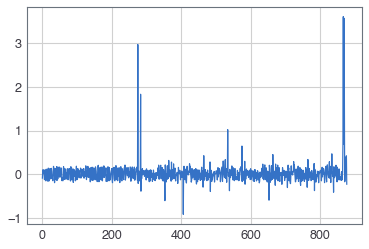

In [199]:
# Visualisatin of means after pre-processing
M = np.mean(X, axis=0)
np.shape(M)

plt.plot(M)
plt.show()

imax = np.argmax(M)

## Train/Validation Split

In [200]:
prop_split = 0.33
if prop_split > 0:
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=prop_split, random_state=42)
    with open("hps/X_train.npz", "wb") as f:
        np.save(f, X_train)
    with open("hps/y_train.npz", "wb") as f:
        np.save(f, y_train)
    with open("hps/X_valid.npz", "wb") as f:
        np.save(f, X_valid)
    with open("hps/y_valid.npz", "wb") as f:
        np.save(f, y_valid)
else:
    X_train, y_train = X, y

## Building Neural Network

In [96]:
def sub_model(in1, in2=None, u=64, a="relu", d=0.0):
    if type(u) is int:
        u = [u for i in range(3)]
    l_dense1 = tf.keras.layers.Dense(u[0], activation=a)
    l_dropout1 = tf.keras.layers.Dropout(d)
    l_dense2 = tf.keras.layers.Dense(u[1], activation=a)
    l_dropout2 = tf.keras.layers.Dropout(d)
    l_dense3 = tf.keras.layers.Dense(u[2], activation=a)
    l_dropout3 = tf.keras.layers.Dropout(d)

    sub_n1_1 = l_dense1(in1)
    sub_n1_do_1 = l_dropout1(sub_n1_1)
    sub_n1_2 = l_dense2(sub_n1_do_1)
    sub_n1_do_2 = l_dropout2(sub_n1_2)
    sub_n1_3 = l_dense3(sub_n1_do_2)
    sub_n1_do_3 = l_dropout3(sub_n1_3)
    
    if in2 is None:
        return sub_n1_do_3
    else:
        sub_n2_1 = l_dense1(in2)
        sub_n2_do_1 = l_dropout1(sub_n2_1)
        sub_n2_2 = l_dense2(sub_n2_do_1)
        sub_n2_do_2 = l_dropout2(sub_n2_2)
        sub_n2_3 = l_dense3(sub_n2_do_2)
        sub_n2_do_3 = l_dropout3(sub_n2_3)
        return sub_n1_do_3, sub_n2_do_3

In [97]:
from tensorflow.keras.layers import Concatenate, Add, Activation, Dense

def vador_model():    
    size_umap_emb = nc
    size_n2v_emb = 128
    size_w2v_emb = 300
    
    d = 0.0
    a = "relu"
    

    inpt = tf.keras.layers.Input((np.shape(X_train)[1],), name='feature')
    
    # features
    cur = 0
    n1_umap = inpt[:, cur:cur+size_umap_emb]
    n2_umap = inpt[:, cur+size_umap_emb:cur+size_umap_emb*2]
    cur += size_umap_emb*2 
    
    n1_n2v = inpt[:, cur:cur+size_n2v_emb]
    n2_n2v = inpt[:, cur+size_n2v_emb:cur+size_n2v_emb*2]
    cur += size_n2v_emb*2
    
    n1_w2v = inpt[:, cur:cur+size_w2v_emb]
    n2_w2v = inpt[:, cur+size_w2v_emb:cur+size_w2v_emb*2]
    cur += size_w2v_emb*2
    
    n1_deg = inpt[:, cur:cur+2]
    n2_deg = inpt[:, cur+2:cur+2*2]
    cur += 2*2
    
    n1_n2_jc = inpt[:, cur:]
    cur += 1
    
    # sub-models
    n1_out, n2_out = sub_model(n1_umap, n2_umap, u=16)
    latent_umap = Concatenate()([n1_out, n2_out])
    
    n1_out, n2_out = sub_model(n1_n2v, n2_n2v, u=[128, 96, 64])
    latent_n2v = Concatenate()([n1_out, n2_out])
    
    n1_out, n2_out = sub_model(n1_w2v, n2_w2v, u=[128, 96, 64])
    latent_w2v = Concatenate()([n1_out, n2_out])
    
    lspace_n1_n2 = Concatenate()([latent_umap, latent_n2v, latent_w2v])
    
    # final layers
    n1_n2_else = Concatenate()([n1_deg, n2_deg, n1_n2_jc])
    lspace_else = sub_model(n1_n2_else, u=16)
    
    merge = Concatenate()([lspace_n1_n2,lspace_else])
    
    logit = sub_model(merge, u=128)
    out = Dense(1, activation="sigmoid")(logit)

    model = tf.keras.Model(inputs=[inpt], outputs=[out])
    return model

model = vador_model()

In [98]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature (InputLayer)            [(None, 878)]        0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_45 (T [(None, 5)]          0           feature[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_46 (T [(None, 5)]          0           feature[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_47 (T [(None, 128)]        0           feature[0][0]                    
____________________________________________________________________________________________

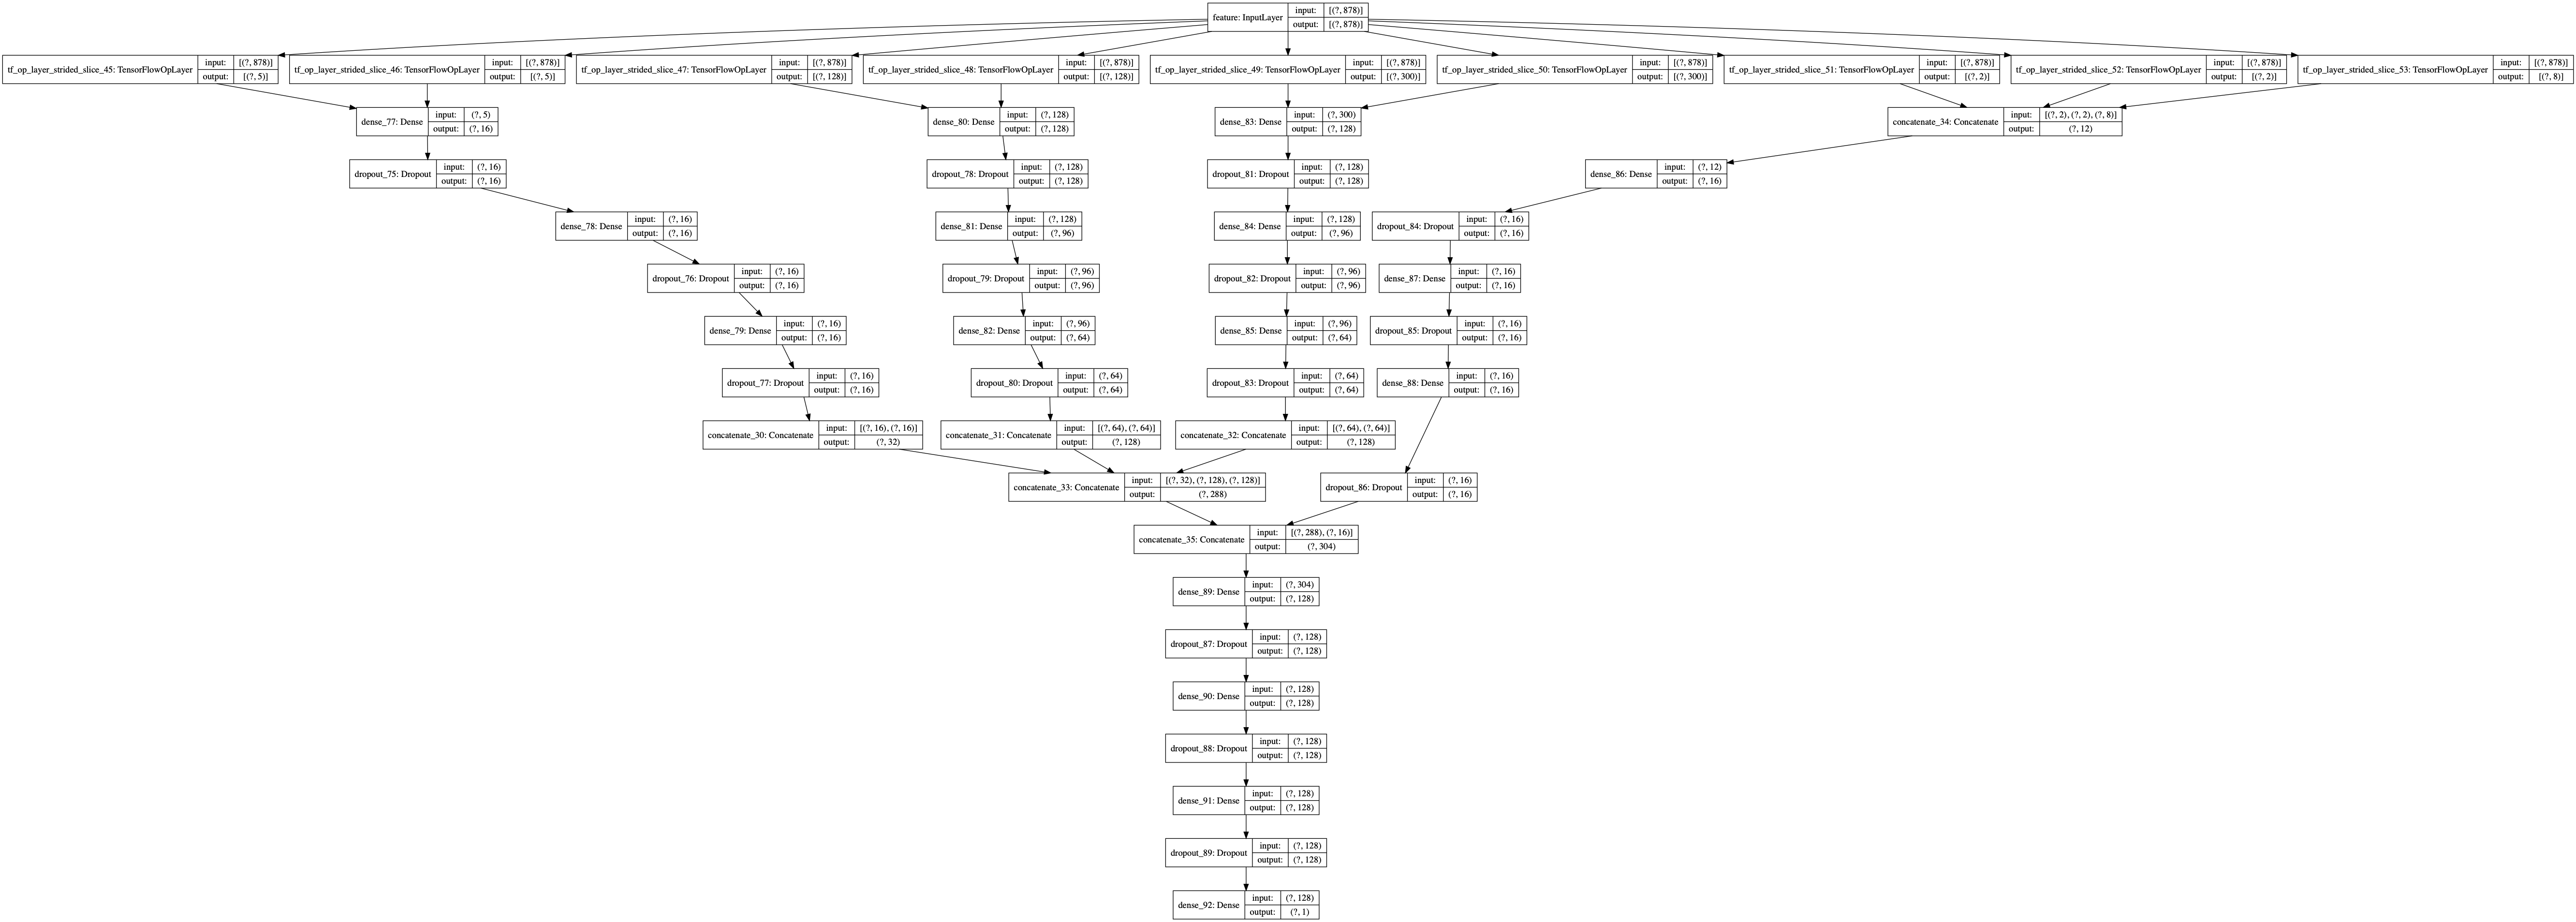

In [99]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Training of Neural Network

In [43]:
lr = 0.001
epochs = 20
batch_size = 32

# opt = tf.keras.optimizers.RMSprop(lr=lr, rho=0.9)
opt = tf.keras.optimizers.Adam(lr=lr)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['acc'])

In [44]:
def decay(epoch):
    if epoch < 3:
        return 1e-3
    elif epoch >= 5 and epoch < 10:
        return 1e-4
    else:
        return 1e-5

In [45]:
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

In [46]:
weights_filepath = "weights.h5"

monitor = "val_acc" if prop_split > 0 else "acc"

callbacks = [
#     tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=weights_filepath,
        monitor=monitor,
        mode='max',
        save_weights_only=True,
        save_best_only=True,
        verbose=1),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [47]:
if prop_split > 0:
    hist = model.fit(
        X_train,
        y_train,
        validation_data=(X_valid, y_valid),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks
    )
else:
    hist = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks
    )

Train on 561546 samples, validate on 62394 samples
Epoch 1/20
561248/561546 [============================>.] - ETA: 0s - loss: 0.1752 - acc: 0.9327
Epoch 00001: val_acc improved from -inf to 0.95469, saving model to weights.h5

Learning rate for epoch 1 is 0.0010000000474974513
561546/561546 [==============================] - 76s 135us/sample - loss: 0.1752 - acc: 0.9327 - val_loss: 0.1216 - val_acc: 0.9547
Epoch 2/20
561152/561546 [============================>.] - ETA: 0s - loss: 0.1330 - acc: 0.9499
Epoch 00002: val_acc improved from 0.95469 to 0.95971, saving model to weights.h5

Learning rate for epoch 2 is 0.0010000000474974513
561546/561546 [==============================] - 71s 126us/sample - loss: 0.1330 - acc: 0.9499 - val_loss: 0.1310 - val_acc: 0.9597
Epoch 3/20
561184/561546 [============================>.] - ETA: 0s - loss: 0.1243 - acc: 0.9534
Epoch 00003: val_acc improved from 0.95971 to 0.96004, saving model to weights.h5

Learning rate for epoch 3 is 0.001000000047497

## Adversarial Training

In [211]:
import neural_structured_learning as nsl

adv_config = nsl.configs.make_adv_reg_config(multiplier=0.2, adv_step_size=0.05)
adv_model = nsl.keras.AdversarialRegularization(model, adv_config=adv_config)

# Compile, train, and evaluate.
adv_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

hist = adv_model.fit(
    {'feature': X_train, 'label': y_train},
    batch_size=32, epochs=30)

Train on 561546 samples
Epoch 1/30
561546/561546 [==============================] - 119s 212us/sample - loss: 0.2110 - binary_crossentropy: 0.1728 - binary_accuracy: 0.9736 - adversarial_loss: 0.1909
Epoch 2/30
561546/561546 [==============================] - 106s 190us/sample - loss: 0.0792 - binary_crossentropy: 0.0639 - binary_accuracy: 0.9800 - adversarial_loss: 0.0769
Epoch 3/30
561546/561546 [==============================] - 107s 190us/sample - loss: 0.0862 - binary_crossentropy: 0.0694 - binary_accuracy: 0.9809 - adversarial_loss: 0.0844
Epoch 4/30
561546/561546 [==============================] - 107s 191us/sample - loss: 0.0647 - binary_crossentropy: 0.0519 - binary_accuracy: 0.9823 - adversarial_loss: 0.0638
Epoch 5/30
561546/561546 [==============================] - 107s 190us/sample - loss: 0.0642 - binary_crossentropy: 0.0514 - binary_accuracy: 0.9825 - adversarial_loss: 0.0640
Epoch 6/30
561546/561546 [==============================] - 107s 190us/sample - loss: 0.0718 - b

In [101]:
hist = hist.history

In [103]:
hist.keys()
hist['acc'] = hist['binary_accuracy']

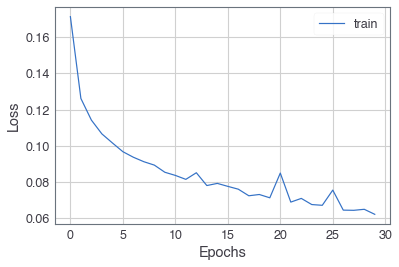

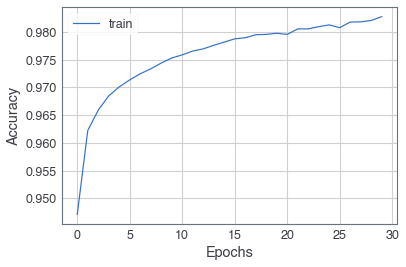

In [106]:
plt.plot(hist['loss'], label="train")
if prop_split > 0 and 'val_loss' in hist.keys():
    plt.plot(hist['val_loss'], label="valid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(hist['acc'], label="train")
if prop_split > 0 and 'val_acc' in hist.keys():
    plt.plot(hist['val_acc'], label="valid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print("max train accuracy: ", np.max(hist['acc']))
if prop_split > 0 and 'val_acc' in hist.keys():
    print("max valid accuracy: ", np.max(hist['val_acc']))

## Prediction on train data

In [222]:
# save weights of last epoch
model.save_weights("last_weights.h5")

In [51]:
# load best weights file
model.load_weights(weights_filepath)

In [217]:
# predict with best weights
y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)

## Tune the decision threshold

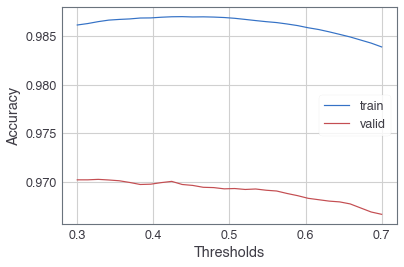

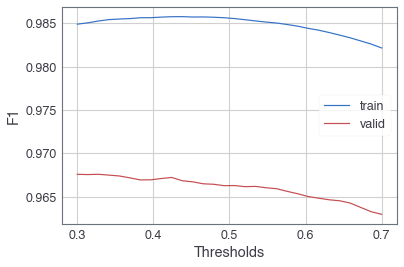

Best accuracy: 0.9702375228387345 for threshold=0.3275862068965517
F1 score: 0.9675876634143787


In [218]:
thresholds = np.linspace(0.3, 0.7, 30)
accl_train = []
accl_valid = []
f1l_train = []
f1l_valid = []
for thresh in thresholds:
    predictions = (y_pred_train >= thresh).astype(int).flatten()
    acc = np.sum(predictions == y_train.flatten()) / len(predictions)
    f1s = f1_score(predictions, y_train.flatten())
    accl_train.append(acc)
    f1l_train.append(f1s)
    
    predictions = (y_pred_valid >= thresh).astype(int).flatten()
    acc = np.sum(predictions == y_valid.flatten()) / len(predictions)
    f1s = f1_score(predictions, y_valid.flatten())
    accl_valid.append(acc)
    f1l_valid.append(f1s)

plt.plot(thresholds, accl_train, "b-", label="train")
plt.plot(thresholds, accl_valid, "r-", label="valid")
plt.ylabel("Accuracy")
plt.xlabel("Thresholds")
plt.legend()
plt.show()

plt.plot(thresholds, f1l_train, "b-", label="train")
plt.plot(thresholds, f1l_valid, "r-", label="valid")
plt.ylabel("F1")
plt.xlabel("Thresholds")
plt.legend()
plt.show()

imax = np.argmax(f1l_valid)
threshold = thresholds[imax]
predictions = (y_pred_valid >= threshold).astype(int).flatten()
f1s = f1_score(predictions, y_valid.flatten())

print(f"Best accuracy: {accl_valid[imax]} for threshold={threshold}")
print(f"F1 score: {f1s}")

## Prediction on test data
Build testing set.

In [202]:
Xt = []
override_testing_data = False

if override_testing_data:
    with open("data/testing.txt", "r") as f:
        for line in tqdm(f):
            line = line.split()
            n1, n2 = line[0], line[1]
            Xt.append(np.concatenate([
                umap_emb[nid_to_index[n1]], 
                umap_emb[nid_to_index[n2]],
                node_emb[n1], 
                node_emb[n2],
                text_emb[n1],
                text_emb[n2],
                [DG.in_degree[n1], DG.out_degree[n1]],
                [DG.in_degree[n2], DG.out_degree[n2]],
                [get_jc(G, n1, n2)]]))

    Xt = np.array(Xt)
    with open("embeddings/testX_part1.npy", "wb") as f:
        np.save(f, Xt)
else:
    with open("embeddings/testX_part1.npy", "rb") as f:
        Xt = np.load(f)
print("Shape Xt: ", np.shape(Xt))

Shape Xt:  (113450, 871)


In [203]:
with open("embeddings/testX_part2.npy", "rb") as f:
    Xt = np.concatenate([Xt, np.load(f)], axis=1)
print("Shape Xt: ", np.shape(Xt))

Shape Xt:  (113450, 878)


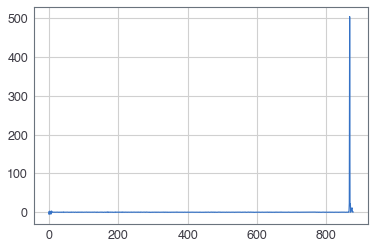

imax =  867


In [204]:
M = np.mean(Xt, axis=0)
np.shape(M)

plt.plot(M)
plt.show()

imax = np.argmax(M)
print("imax = ", imax)

In [205]:
Xt = preprocessor.transform(Xt)

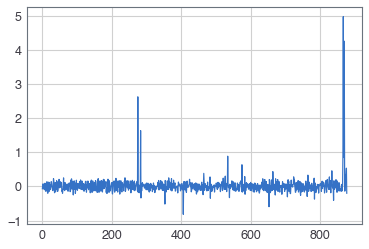

imax =  867


In [212]:
M = np.mean(Xt, axis=0)
np.shape(M)

plt.plot(M)
plt.show()

imax = np.argmax(M)
print("imax = ", imax)

In [147]:
print(np.shape(Xt))

(113450, 878)


In [213]:
y_pred = model.predict(Xt)

In [219]:
predictions = (y_pred >= threshold).astype(int).flatten()
acc = 0
with open("data/testing.txt", "r") as f:
    for i, line in tqdm(enumerate(f)):
        line = line.split()
        n1, n2 = line[0], line[1]
        if (G.degree(n1) == 0 or G.degree(n2) == 0) and predictions[i]:
            predictions[i] == 0 # correction for some nodes
            acc += 1
print(acc)

113450it [00:00, 170773.31it/s]

88


In [220]:
def save_predictions(y, filename):
    """
    Save predictions y (0, 1 values) to a csv
    """
    predictions = zip(range(len(y)), y)
    # Write the output in the format required by Kaggle
    with open(filename,'w') as pred:
        csv_out = csv.writer(pred)
        csv_out.writerow(['id','predicted'])
        for row in predictions:
            csv_out.writerow(row) 
    print('Saved predictions to', filename)

In [221]:
save_predictions(predictions, 'out2.csv')

Saved predictions to out2.csv
